In [5]:
import seaborn as sns
import networkx as nx
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import rospkg
import pandas as pd
import numpy as np
import yaml
import math
import matplotlib.cm as cm
import matplotlib
import os, sys, shutil
import plotly

def color_map_color(value, cmap_name='Reds', vmin=0, vmax=1):
    # norm = plt.Normalize(vmin, vmax)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)  # PiYG
    rgb = cmap(norm(abs(value)))[:3]  # will return rgba, we take only first 3 so we get rgb
    color = matplotlib.colors.rgb2hex(rgb)
    return color

dirname = rospkg.RosPack().get_path('mrpp_sumo')

In [6]:
#name of the yaml/output files
name = 'arv25'

#path to directory containing 'config' and 'outputs'
# dirdata = '/home/sdeepakmallya/data_hd/mrpp_sumo_backup/27_01_2021'

# sim_dir = dirdata + '/post_process/' + name
# os.mkdir(sim_dir)
# shutil.copy('{}/config/{}.yaml'.format(dirdata, name), sim_dir)
# shutil.copy('{}/outputs/{}_visits.in'.format(dirdata, name), sim_dir)
# shutil.copy('{}/outputs/{}_command.in'.format(dirdata, name), sim_dir)
# shutil.copy('{}/outputs/{}_vehicle.xml'.format(dirdata, name), sim_dir)

In [7]:
#get config and parameters
with open('{}/config/{}.yaml'.format(dirname,name), 'r') as f:
    config = yaml.load(f, yaml.FullLoader)
# print(config)

graph = nx.read_graphml(dirname + '/graph_ml/{}.graphml'.format(config['graph']))
nodes = list(graph.nodes())
edges = [graph[e[0]][e[1]]['name'] for e in list(graph.edges())]
n = len(nodes)
num_bots = int(config['init_bots'])
sim_length = int(config['sim_length'])
algo_name = config['algo_name']

In [8]:
#read visits.in data for a given config
cols_n = ['time']
cols_n.extend(nodes)
df1 = pd.DataFrame(columns = cols_n)
cols_e = ['time']
cols_e.extend(edges)
df2 = pd.DataFrame(columns = cols_e)
df3 = pd.DataFrame(columns = nodes, index = ['bot_{}'.format(i) for i in range(num_bots)])
df3 = df3.fillna(0)     

bot_visit_seq = {}
for bot in range(num_bots):
    bot_visit_seq['bot_{}'.format(bot)] = pd.DataFrame(columns=['time', 'node']) 

with open('{}/outputs/{}_visits.in'.format(dirname, name), 'r') as f:
    robots = {}
    i = 0
    cur_time = 0
    cur_data_n = {}
    cur_data_e = {}
    for n in df1.columns:
        cur_data_n[n] = cur_time
    for e in df2.columns:
        cur_data_e[e] = cur_time

    for l in f.readlines():
        i += 1
        if i % 3 == 1:
            next_time = float(l)
            while cur_time < next_time:
                df1 = df1.append(cur_data_n, ignore_index = True)
                df2 = df2.append(cur_data_e, ignore_index = True)
                cur_time += 1
                cur_data_n['time'] = cur_time
                cur_data_e['time'] = cur_time
                for n in nodes:
                    cur_data_n[n] += 1
                
        elif i % 3 == 2:
            cur_nodes = l.strip('\n').split(' ')
            for n in cur_nodes:
                cur_data_n[n] = 0
        else:
            cur_robots = l.strip('\n').split(' ')

            for r in range(len(cur_robots)):
                bot_visit_seq[cur_robots[r]] = bot_visit_seq[cur_robots[r]].append({'time': next_time, 'node': cur_nodes[r]}, ignore_index = True)
                if not cur_robots[r] in robots.keys():
                    robots[cur_robots[r]] = cur_nodes[r]
                    df3[cur_nodes[r]][cur_robots[r]] += 1
                else:
                    try:
                        cur_data_e[graph[robots[cur_robots[r]]][cur_nodes[r]]['name']] += 1
                        robots[cur_robots[r]] = cur_nodes[r]
                        df3[cur_nodes[r]][cur_robots[r]] += 1
                    except:
                        pass
df1 = df1.set_index('time')
df2 = df2.set_index('time')

# df1.to_csv(sim_dir + '/{}_node.csv'.format(name))
# df2.to_csv(sim_dir + '/{}_edge.csv'.format(name))
# df3.to_csv(sim_dir + '/{}_bot.csv'.format(name))

In [9]:

sns.set_style('white')
sns.set_context(font_scale= 1, rc = {"font.size" : 15, "axes.titlesize" : 40})

# plt.subplots_adjust(top= 0.2)
# sns.set(rc = {'figure.figsize':(12000, 100)})
for bot in bot_visit_seq.keys():
    fig = plt.subplot()
    plt.subplots(figsize = (20, 20))
    sns.scatterplot(data= bot_visit_seq[bot], y = 'node', x = 'time', style='node', legend = False)
    plt.suptitle('Node Visit Instance vs Time ({})'.format(bot), size = 36, x = 0.4, y=0.98)

# sns.lineplot(data = df1.iloc[::100], x = 'time', y = df1.loc[::100, nodes].mean(axis = 1), legend = False, linewidth = 3)
    plt.xticks(rotation = 30)
    plt.yticks(rotation = 30)
# fig.set_yticks(list(range(num_bots)))
# fig.set_yticklabels(['bot_{}'.format(bot) for bot in range(0, num_bots)])
    plt.ylabel('Node ID')
# plt.show()
    plt.savefig('/home/sdeepakmallya/{}_scatter.png'.format(bot), bbox_inches = 'tight')

KeyboardInterrupt: 

In [26]:
mask = bot_visit_seq['bot_0']['time'] < 15000
bot_visit_seq['bot_0'][mask]

,time,node
0,0.0,667357387
1,16.0,-22
2,36.0,667357387
3,56.0,667357382
4,78.0,3215340464
...,...,...
621,14909.0,-282
622,14933.0,-266
623,14956.0,-22
624,14975.0,667357387


6


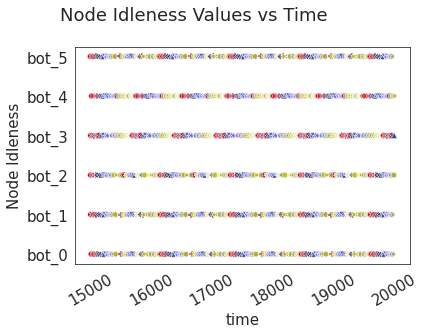

In [34]:
fig = plt.subplot()
sns.set_style('white')
sns.set_context(font_scale= 1, rc = {"font.size" : 15, "axes.titlesize" : 20})
# plt.subplots(figsize = (10, 20))
# plt.subplots_adjust(top= 0.2)
# sns.set(rc = {'figure.figsize':(12000, 100)})
for bot in bot_visit_seq.keys():
    mask = bot_visit_seq[bot]['time'] >= 15000
    sns.scatterplot(data= bot_visit_seq[bot][mask], y = [int(bot.split('_')[1])] * bot_visit_seq[bot][mask].shape[0], x = 'time', style='node', hue='node', legend = False, palette= 'gist_stern')
plt.suptitle('Node Idleness Values vs Time', size = 18, y = 1.02, x = 0.4)

# sns.lineplot(data = df1.iloc[::100], x = 'time', y = df1.loc[::100, nodes].mean(axis = 1), legend = False, linewidth = 3)
plt.xticks(rotation = 30)
fig.set_yticks(list(range(num_bots)))
fig.set_yticklabels(['bot_{}'.format(bot) for bot in range(0, num_bots)])
plt.ylabel('Node Idleness')
# plt.show()
plt.savefig('/home/sdeepakmallya/{}_scatter.png'.format(name), 
bbox_inches='tight')
print(num_bots)

Text(18.34313472222223, 0.5, 'Node Idleness')

<Figure size 1440x7200 with 0 Axes>

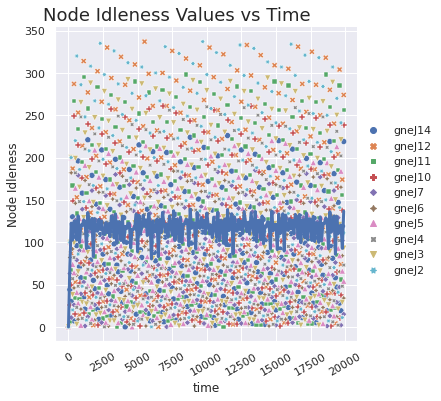

In [29]:
# plot scatter plot of idleness vs time for all nodes
# dpi1 = 100
plt.figure()
sns.set_style('white')
sns.set_context(font_scale= 1, rc = {"font.size" : 15, "axes.titlesize" : 20})
# plt.subplots(figsize = (10, 20))
# plt.subplots_adjust(top= 0.2)
sns.set(rc = {'figure.figsize':(20, 100)})
sns.relplot(data= df1.loc[::100], kind='scatter')
plt.suptitle('Node Idleness Values vs Time', size = 18, y = 1.02, x = 0.4)
sns.lineplot(data = df1.iloc[::100], x = 'time', y = df1.loc[::100, nodes].mean(axis = 1), legend = False, linewidth = 3)
plt.xticks(rotation = 30)
plt.ylabel('Node Idleness')
# plt.show()
# plt.savefig('{}/{}_scatter.png'.format(sim_dir, name), bbox_inches='tight')

In [6]:
# plotly.io.orca.config.executable = '/usr/lib/python3/dist-packages'
d = 20 #radius of nodes
edge_x = []
edge_y = []
for edge in graph.edges():
    x0, y0 = graph.nodes[edge[0]]['x'], graph.nodes[edge[0]]['y']
    x1, y1 = graph.nodes[edge[1]]['x'], graph.nodes[edge[1]]['y']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

# edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.5, color='#888', shape = 'linear'), hoverinfo='none', mode='lines')

node_x = []
node_y = []
avg_idle = []
max_idle = []
for node in graph.nodes():
    x, y = graph.nodes[node]['x'], graph.nodes[node]['y']
    node_x.append(x)
    node_y.append(y)
    # avg_idle.append(df1[node].mean())
    # max_idle.append(df1[node].max())

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=False,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Blues',
        reversescale=False,
        color='white',
        size=2 * d,
        # opacity = 0.5,
        # showscale = False,
        # colorbar=dict(
        #     thickness=15,
        #     title='Node Connections',
        #     xanchor='left',
        #     titleside='right'
        # ),
        line_width=2))

In [7]:
#visualizing graph

fig = go.Figure(data=[node_trace],
            layout=go.Layout(
            title='Graph \'{}\''.format(config['graph']),
            titlefont_size=16,
            showlegend=False,
            hovermode='closest',
            margin=dict(b=20,l=5,r=5,t=40),
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            width=1200,
            height=1000)
            )

# fig.add_trace(go.Heatmap(x = node_x, y = node_y, z = node_z))
for i in range(0, len(edge_x), 3):
    # print (edge_x[i])
    x0 = edge_x[i + 1]  # arrows' head
    y0 = edge_y[i + 1]  # arrows' head
    x1 = edge_x[i]  # arrows' tail
    y1 = edge_y[i]  # arrows' tail
    # print (x0, y0, x1, y1)

    vert = True
    if x0 != x1:
        m = (y1 - y0)/(x1 - x0)
        c = y0 - m * x0
        vert = False
    
    if vert:
        yt = y0 + d/2 * np.sign(y1 - y0)
        yh = y1 - d/2 * np.sign(y1 - y0)
        xt = x0
        xh = x1
    else:
        if y1 == y0:
            xt = x0 + d/2 * np.sign(x1 - x0)
            xh = x1 - d/2 * np.sign(x1 - x0)
            yt = y0
            yh = y1
        else:
            xt = x0 + math.sqrt((d) ** 2 / (m ** 2 + 1)) * np.sign(x1 - x0)
            xh = x1 - math.sqrt((d) ** 2 / (m ** 2 + 1)) * np.sign(x1 - x0)
            yt = m * xt + c
            yh = m * xh + c
    

    fig.add_annotation(
        x=xh,  # arrows' head
        y=yh,  # arrows' head
        ax=xt,  # arrows' tail
        ay=yt,  # arrows' tail
        xref='x',
        yref='y',
        axref='x',
        ayref='y',
        text='',  # if you want only the arrow
        showarrow=True,
        arrowhead=1,
        arrowsize=2,
        arrowwidth=1,
        arrowcolor='black'
        )
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
)

fig.update_layout(title_x=0.5, titlefont_size = 20, plot_bgcolor = 'rgba(0, 0, 0, 0)')
fig.to_image(format="png", engine="kaleido")
# fig.write_image('{}/{}_graph.png'.format(sim_dir, name))
fig.show()



In [10]:
#color map of average idleness
avg_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Blues',
        reversescale=False,
        color=avg_idle,
        size=2 * d,
        # cmin = 0.,
        # cmax = 200.,
        # opacity = 0.5,
        # showscale = False,
        colorbar=dict(
            thickness=15,
            title='Avg. Node<br>Idleness',
            xanchor='right',
            titleside='top',
        ),
        line_width=0))
# avg_trace.marker.cmin = 200

fig = go.Figure(data=[avg_trace],
            layout=go.Layout(
            title='Graph \'{}\''.format(config['graph']),
            titlefont_size=16,
            showlegend=False,
            hovermode='closest',
            margin=dict(b=20,l=5,r=0,t=40),
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            width=1200,
            height=1000))

# fig.add_trace(go.Heatmap(x = node_x, y = node_y, z = node_z))
for i in range(0, len(edge_x), 3):
    # print (edge_x[i])
    x0 = edge_x[i + 1]  # arrows' head
    y0 = edge_y[i + 1]  # arrows' head
    x1 = edge_x[i]  # arrows' tail
    y1 = edge_y[i]  # arrows' tail
    # print (x0, y0, x1, y1)

    vert = True
    if x0 != x1:
        m = (y1 - y0)/(x1 - x0)
        c = y0 - m * x0
        vert = False
    
    if vert:
        yt = y0 + d * np.sign(y1 - y0)
        yh = y1 - d * np.sign(y1 - y0)
        xt = x0
        xh = x1
    else:
        if y1 == y0:
            xt = x0 + d * np.sign(x1 - x0)
            xh = x1 - d * np.sign(x1 - x0)
            yt = y0
            yh = y1
        else:
            xt = x0 + math.sqrt(d ** 2 / (m ** 2 + 1)) * np.sign(x1 - x0)
            xh = x1 - math.sqrt(d ** 2 / (m ** 2 + 1)) * np.sign(x1 - x0)
            yt = m * xt + c
            yh = m * xh + c
    

    fig.add_annotation(
        x=xh,  # arrows' head
        y=yh,  # arrows' head
        ax=xt,  # arrows' tail
        ay=yt,  # arrows' tail
        xref='x',
        yref='y',
        axref='x',
        ayref='y',
        text='',  # if you want only the arrow
        showarrow=True,
        arrowhead=1,
        arrowsize=2,
        arrowwidth=1,
        arrowcolor='black'
        )
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
)
fig.update_layout(title_text='Average Node Idleness', title_x=0.5, titlefont_size = 20, plot_bgcolor = 'rgba(0, 0, 0, 0)')
fig.to_image(format="png", engine="kaleido")
fig.write_image('{}/{}_avg_idle.png'.format(sim_dir, name))
fig.show()


In [11]:
#color map of maximum idleness
max_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Blues',
        reversescale=False,
        color=max_idle,
        size=2 * d,
        # cmin = 0.,
        # cmax = 300.,
        # opacity = 0.5,
        # showscale = False,
        colorbar=dict(
            thickness=15,
            title='Max. Node<br>Idleness',
            xanchor='right',
            titleside='top'
        ),
        line_width=0))

fig = go.Figure(data=[max_trace],
            layout=go.Layout(
            # title='Graph \'{}\''.format(config['graph']),
            # titlefont_size=16,
            showlegend=False,
            hovermode='closest',
            margin=dict(b=20,l=5,r=0,t=40),
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False), 
            width=1200,
            height=1000)
            )

# fig.add_trace(go.Heatmap(x = node_x, y = node_y, z = node_z))
for i in range(0, len(edge_x), 3):
    # print (edge_x[i])
    x0 = edge_x[i + 1]  # arrows' head
    y0 = edge_y[i + 1]  # arrows' head
    x1 = edge_x[i]  # arrows' tail
    y1 = edge_y[i]  # arrows' tail
    # print (x0, y0, x1, y1)

    vert = True
    if x0 != x1:
        m = (y1 - y0)/(x1 - x0)
        c = y0 - m * x0
        vert = False
    
    if vert:
        yt = y0 + d * np.sign(y1 - y0)
        yh = y1 - d * np.sign(y1 - y0)
        xt = x0
        xh = x1
    else:
        if y1 == y0:
            xt = x0 + d * np.sign(x1 - x0)
            xh = x1 - d * np.sign(x1 - x0)
            yt = y0
            yh = y1
        else:
            xt = x0 + math.sqrt(d ** 2 / (m ** 2 + 1)) * np.sign(x1 - x0)
            xh = x1 - math.sqrt(d ** 2 / (m ** 2 + 1)) * np.sign(x1 - x0)
            yt = m * xt + c
            yh = m * xh + c
    

    fig.add_annotation(
        x=xh,  # arrows' head
        y=yh,  # arrows' head
        ax=xt,  # arrows' tail
        ay=yt,  # arrows' tail
        xref='x',
        yref='y',
        axref='x',
        ayref='y',
        text='',  # if you want only the arrow
        showarrow=True,
        arrowhead=1,
        arrowsize=2,
        arrowwidth=1,
        arrowcolor='black'
        )
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
)
fig.update_layout(title_text='Maximum Node Idleness', title_x=0.5, titlefont_size = 20, plot_bgcolor = 'rgba(0, 0, 0, 0)')
fig.to_image(format="png", engine="kaleido")
fig.write_image('{}/{}_max_idle.png'.format(sim_dir, name))
fig.show()


In [12]:
#color map of probability of next node
next_edge_count = dict(df2.iloc[-1])
next_edge_count.pop('time')
prob_next_visit = {}
for n in nodes:
    succ = list(graph.successors(n))
    total_visits = 0
    for s in succ:
        total_visits += next_edge_count[graph[n][s]['name']]
    for s in succ:
        prob_next_visit[graph[n][s]['name']] = next_edge_count[graph[n][s]['name']]/total_visits

# print(prob_next_visit)
# print(edges)
max_count = max(list(next_edge_count.values()))
# print(max_count)
l = 100
edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.5, color='#888', shape = 'linear'), opacity= 0.5, hoverinfo='none', mode='lines')

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=False,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Blues',
        reversescale=False,
        color=[],
        size=2 * d,
        # cmin = 0.,
        # cmax = 300.,
        # opacity = 0.5,
        # showscale = False,
        colorbar=dict(
            thickness=15,
            title='Max. Node<br>Idleness',
            xanchor='right',
            titleside='top'
        ),
        line_width=0))

fig = go.Figure(data=[node_trace, edge_trace],
            layout=go.Layout(
            # title='Graph \'{}\''.format(config['graph']),
            # titlefont_size=16,
            showlegend=False,
            hovermode='closest',
            margin=dict(b=20,l=5,r=0,t=40),
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            width=1200,
            height= 1000)
            )

# fig.add_trace(go.Heatmap(x = node_x, y = node_y, z = node_z))
for i in range(0, len(edge_x), 3):
    # print (edge_x[i])
    e = edges[i//3]
    len_e  = prob_next_visit[e] * l
    x0 = edge_x[i + 1]  # arrows' head
    y0 = edge_y[i + 1]  # arrows' head
    x1 = edge_x[i]  # arrows' tail
    y1 = edge_y[i]  # arrows' tail
    # print (x0, y0, x1, y1)

    vert = True
    if x0 != x1:
        m = (y1 - y0)/(x1 - x0)
        c = y0 - m * x0
        vert = False
    
    if vert:
        yt = y0 + d * np.sign(y1 - y0)
        yh = yt + len_e * np.sign(y1 - y0)
        xt = x0
        xh = x1
    else:
        if y1 == y0:
            xt = x0 + d * np.sign(x1 - x0)
            xh = xt + len_e * np.sign(x1 - x0)
            yt = y0
            yh = y1
        else:
            xt = x0 + math.sqrt(d ** 2 / (m ** 2 + 1)) * np.sign(x1 - x0)
            xh = xt + math.sqrt(len_e ** 2 / (m ** 2 + 1)) * np.sign(x1 - x0)
            yt = m * xt + c
            yh = m * xh + c
    
    cval = color_map_color(value = next_edge_count[e], vmin = 0, vmax = max_count)
    # print(cval)
    fig.add_annotation(
        x=xh,  # arrows' head
        y=yh,  # arrows' head
        ax=xt,  # arrows' tail
        ay=yt,  # arrows' tail
        xref='x',
        yref='y',
        axref='x',
        ayref='y',
        text='',  # if you want only the arrow
        showarrow=True,
        arrowhead=1,
        arrowsize=2,
        arrowwidth=1,
        arrowcolor=cval,
        )
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
)
fig.update_layout(title_text = 'Distribution over Neighbours', title_x=0.5, titlefont_size = 20, plot_bgcolor = 'rgba(0, 0, 0, 0)')
fig.to_image(format="png", engine="kaleido")
fig.write_image('{}/{}_dist_neigh.png'.format(sim_dir, name))
fig.show()


In [15]:
#Bot Histogram
edge_trace = go.Scatter3d(x=edge_x, y=edge_y, z=[0] * len(edge_x), opacity=1, hoverinfo='none', mode='lines')

node_trace = go.Scatter3d(
    x=node_x, y=node_y,z=[0] * len(nodes),
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=False,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Blues',
        reversescale=False,
        color=[],
        size=2 * d/10,
        cmin = 0.,
        cmax = 300.,
        # opacity = 0.5,
        # showscale = False,
        colorbar=dict(
            thickness=15,
            title='Max. Node<br>Idleness',
            xanchor='right',
            titleside='top'
        ),
        line_width=0))

fig = go.Figure(data=[node_trace, edge_trace],
            layout=go.Layout(
            title='Bot Visit Count',
            # titlefont_size=16,
            showlegend=False,
            hovermode='closest',
            margin=dict(b=20,l=5,r=0,t=40),
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
            )

for bot in df3.index:
    # print(bot)
    h = [df3[n][bot] for n in nodes]
    fig.add_trace(go.Mesh3d(x = node_x, y = node_y, z = h, opacity= 0.3, name = bot))
fig.update_layout(title_x=0.5)
fig.update_traces(alphahull = -1, selector= dict(type = 'mesh3d'))
fig.write_html('{}/{}_visit_count.html'.format(sim_dir, name))
fig.show()

In [20]:
df_temp = pd.DataFrame(columns=['use_sim_time', 'sim_length', 'graph', 'algo_name', 'init_bots', 'init_locations', 'random_string'])
df_temp.set_index('random_string')
df_temp.to_csv(dirname + '/results_compiled.csv', index = False)
df = pd.read_csv(dirname + '/results_compiled.csv')
df.columns

Index(['use_sim_time', 'sim_length', 'graph', 'algo_name', 'init_bots',
       'init_locations', 'random_string'],
      dtype='object')

In [14]:
import glob

config_files = glob.glob('/home/sdeepakmallya/sim_copy/config/*.yaml')


In [18]:
count = []
for c in config_files:
    d = c.split('/')
    d = d[-1].split('.')[0]
    if os.path.exists('{}/outputs/{}_visits.in'.format(dirname, d)):
        shutil.copy('{}/outputs/{}_visits.in'.format(dirname, d), '/home/sdeepakmallya/sim_copy/outputs')
    else:
        count.append(d)

In [11]:
a = {'fad': 123}
b = a.copy()
b['afsdf'] = None
print(a, b)
print(np.max(avg_idle))
df = pd.read_csv(dirname + '/results_compiled.csv')
print(df.columns)
for i in b.keys():
    print(i in df.columns)

{'fad': 123} {'fad': 123, 'afsdf': None}
189.04425221261064
Index(['use_sim_time', 'sim_length', 'graph', 'algo_name', 'init_bots',
       'init_locations', 'random_string'],
      dtype='object')
False
False


In [6]:
# import pandas as pandas

df = pd.read_csv(dirname + '/results_compiled.csv')
df['random_string']

0      arv9
1     arv39
2     arv35
3     arv66
4     arv51
      ...  
79    arv23
80    arv79
81    arv80
82    arv73
83    arv24
Name: random_string, Length: 84, dtype: object